In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

In [3]:
function generate_input_data(beta::Float64)
    lambda = 1e+5
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = (0.3/(input_smpl[i]-1.)    #G(iw) = 1/(iw-1)
                             + 0.5/(input_smpl[i]+3.)    #G(iw) = 1/(iw+3)
                             + 0.2/(input_smpl[i]-4.5)) #G(iw) = 1/(iw-4.5)
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [4]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(beta)
;

In [5]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [8]:
Lorentzian(x, mu, gamma) = gamma/(pi*((x-mu)^2+gamma^2))
rho(omega) = 0.3*Lorentzian(omega, 1.0, eta) + 0.5*Lorentzian(omega, -3.0, eta) + 0.2*Lorentzian(omega, 4.5, eta)
omegas = LinRange(-omega_max, omega_max, N_real)
;

In [9]:
@time wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false, pick_check=false)
;

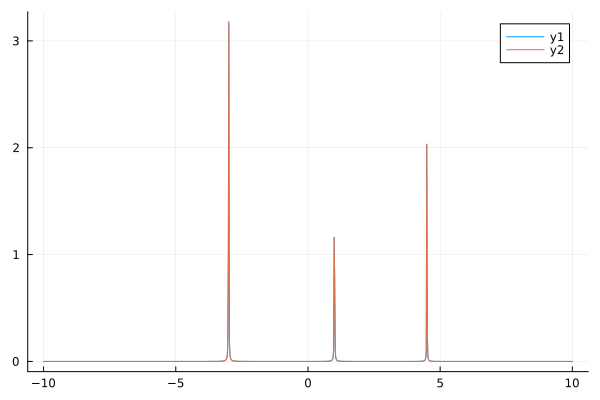

In [10]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [44]:
#=
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    #xmirror = true, 
    xticks = [5,0,-5],
    yticks = [3,0],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20),
    framestyle=:box,
    size = (400,200)
    )
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho(\\omega)"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="w/o opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
#savefig("delta_function.svg")
=#

In [42]:
open("data/delta_wo_opt.dat","w") do f
    for i in 1:wo_sol.reals.N_real
        println(f, "$(Float64(real.(wo_sol.reals.freq[i])))",  "\t", "$(Float64(imag.(wo_sol.reals.val[i]/pi)))")
    end
end
open("data/delta_exact.dat","w") do g
    for i in 1:length(omegas)
        println(g, omegas[i],  "\t", rho(omegas[i]))
    end
end